In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import pymc3 as pm
from theano import shared
import theano.tensor as tt
import theano
from pymc3.distributions.dist_math import binomln, betaln, bound
from collections import Counter
np.set_printoptions(suppress=True)

In [2]:
import re
def plot_traces(trcs, varnames=None):
    '''Plot traces with overlaid means and values'''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)

    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4),
                      lines={k: v['mean'] for k, v in
                             pm.summary(trcs,varnames=varnames).iterrows()})

    for i, mn in enumerate(pm.summary(trcs, varnames=varnames)['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data',
                         xytext=(5,10), textcoords='offset points', rotation=90,
                         va='bottom', fontsize='large', color='#AA0022')
def strip_derived_rvs(rvs):
    '''Remove PyMC3-generated RVs from a list'''

    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)
    return ret_rvs

In [104]:
# Load the data and process it.

df = pd.read_csv("../mturk_surveys.csv")
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))

# Create a list of all unique worker IDs 
workers = pd.DataFrame(list(set(df.worker_id)), columns=['worker_id']).reset_index().set_index('worker_id')

# Calculate the time period of each survey answer. 
# Below we take out time period to be 30-day periods. 
# We can change this to be weeks, months, or anything else
window_length = 30
minDate = min(df['date'])
df['period'] = (df['date'] - minDate).dt.days // window_length 

# Fix the issue of duplicate records within the same period.
data = df[['worker_id', 'period']].drop_duplicates().pivot_table(
    index = 'worker_id',
    values = 'period',                    
    aggfunc=('count','min','max')
).join(workers).set_index('index').sort_index()

# Aggregate the capture histories
#data = data.groupby(['min', 'max', 'count']).size().reset_index(name='count_history')

In [105]:
S = 35
dat = np.zeros(S + 1)
out = Counter(data['count'].values)

In [106]:
for k,v in out.items():
    dat[k] = v

In [107]:
V = len(workers)
print(S, V)

35 46145


In [94]:
dat = np.array([0,25,22,13,5,1,2])
S = 6
V = data.sum()
print(S, V)

6 68


In [156]:
def logp_capture(alpha, beta, U, D, S):
    def ll_capture_f(ni):
        
        # useful vars
        i = tt.arange(S + 1)
        
        # At least one capture
        # binomln(n, k) + betaln(k + alpha, n - k + beta) - betaln(alpha, beta)
        
        #binomln
        Li =  tt.gammaln(S + 1) - tt.gammaln(i + 1) - tt.gammaln(S - i + 1)
        
        # betaln(i + alpha, n - i + beta)
        # betaln = gammaln(x) + gammaln(y) - gammaln(x + y)
        
        Li += tt.gammaln(i + alpha) + tt.gammaln(S - i + beta) - tt.gammaln(S + alpha + beta)
        
        # - betaln(alpha, beta)
        # gammaln(x) + gammaln(y) - gammaln(x + y)
        
        Li += tt.gammaln(alpha + beta) - tt.gammaln(alpha) - tt.gammaln(beta)
        
        # No captures
        #(betaln(alpha, S + beta) - betaln(alpha, beta))
        
        L0  = tt.gammaln(S + beta) - tt.gammaln(S + alpha + beta) + tt.gammaln(alpha + beta) - tt.gammaln(beta)
        
        # Likelihood
        obj1 = tt.gammaln(D+U+1) - tt.gammaln(U+1.0) - tt.sum(tt.gammaln(ni+1))
        obj2 = tt.sum(tt.mul(ni, Li))
        obj3 = U * L0
        objective = obj1 + obj2 + obj3 
        
        #print(tt.exp(Li).eval())
        return objective
    
    return ll_capture_f

In [ ]:
# custom log-liklihood model
with pm.Model() as model:
    # parameters
    U = pm.Uniform('Unseen', lower=0, upper=1000000)
    a = pm.Uniform('alpha', 0., 100.)
    b = pm.Uniform('beta', 0., 100.)
    # Model Log-likelihood
    ob = pm.c('x', logp_capture(a, b, U, V, S), observed=dat)

In [ ]:
with model:
  posterior = pm.sample(5000, tune = 100, chains = 4)

/Users/ded/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


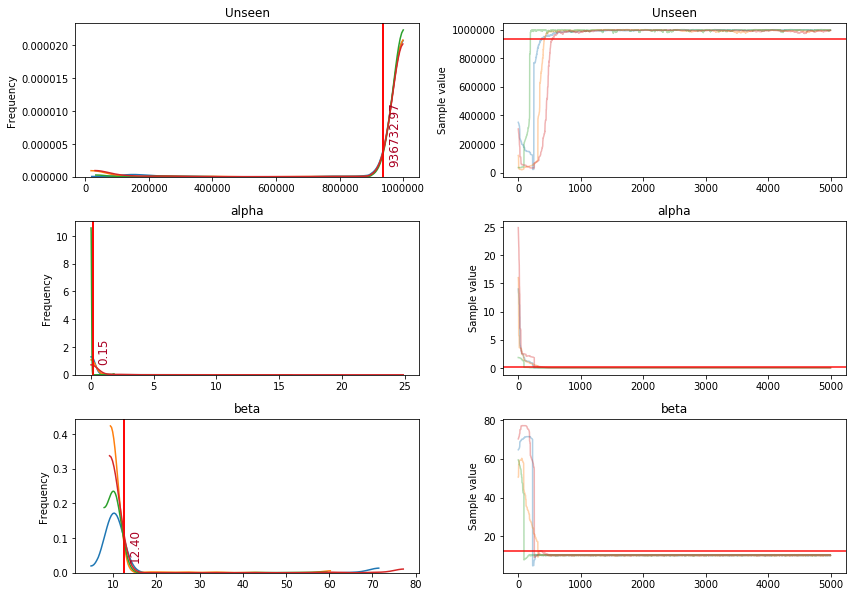

In [159]:
plot_traces(posterior)

In [160]:
pm.summary(posterior)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Unseen,936732.968771,212467.979502,20429.995910,219069.476961,999952.412707,49.503950,1.007095
alpha,0.151218,0.943615,0.061329,0.028779,0.242126,172.138861,1.003407
beta,12.404060,10.371874,0.957132,9.291606,12.490452,82.320861,1.005451


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c23d1d3c8>,
      dtype=object)

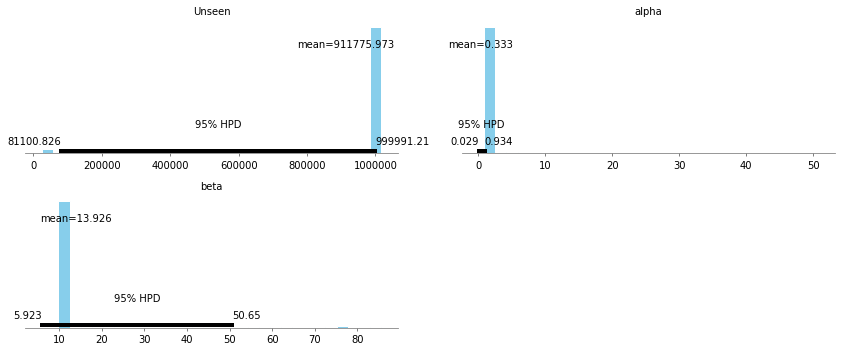

In [113]:
pm.plot_posterior(posterior)

In [124]:
with model:
    x2ppc = pm.sample_ppc(posterior, 1000)






  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: Distribution was not passed any random method Define a custom random method and pass it as kwarg random

In [52]:
plt.bar(dat)

TypeError: bar() missing 1 required positional argument: 'height'

<BarContainer object of 36 artists>

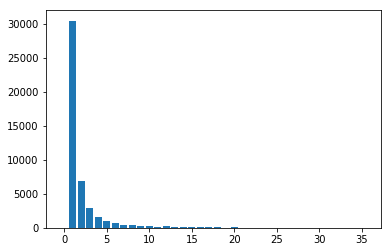

In [53]:
plt.bar(np.arange(len(dat)), dat)

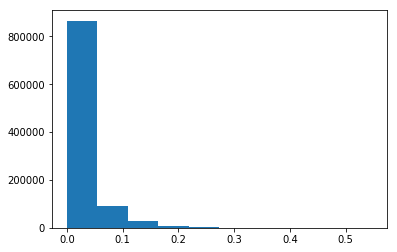

In [145]:
plt.hist(pm.Beta.dist(alpha = 0.33, beta = 14).random(size = 1000000));

In [150]:
.9**20

0.12157665459056935

In [55]:
data['count' ==  1]

KeyError: False

In [90]:
pm.Multinomial.dist(n = 1000, p = [.1, .3, 0.6]).random()

array([ 87., 313., 600.])

In [56]:
data['count' = 1]

SyntaxError: invalid syntax (<ipython-input-56-1f51b0a71978>, line 1)

In [73]:
data[(data['count'] == 1) & (data['min'] == 30)]

,count,max,min
index,,,
133,1,30,30
163,1,30,30
328,1,30,30
489,1,30,30
507,1,30,30
597,1,30,30
776,1,30,30
790,1,30,30
913,1,30,30
